# Party Classification by Tweet

In this notebook I will build a model that classifies tweets as either coming from a Democrat or a Republican politcian. To train my model I will use a collection of the latest 200 tweets (as of May 17th, 2018) from every member of the House of Representatives. This data set can be found at https://www.kaggle.com/kapastor/democratvsrepublicantweets#ExtractedTweets.csv

In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import re


The collection of tweets is stored under the variable 'data', the corresponding party label will stored stored under 'targets', we see that the data set has 86,460 samples

In [2]:
data=pd.read_csv('ExtractedTweets.csv')['Tweet']
targets=pd.read_csv('ExtractedTweets.csv')[['Party']]
data.shape

(86460,)

First, I do some preprocessing, the following for loop removes all apostrophes and URLs from the tweet data set

In [3]:
for i in range(len(data)):
    data[i]=data[i].replace("’","")
    data[i]=data[i].replace("''","")
    data[i]=re.sub(r"http\S+", "", data[i])
    data[i]=' '.join(s for s in data[i].split() if not any(c.isdigit() for c in s))
    


Next, I use the CountVectorizer utility to turn the tweets into a bag of words model, this will convert each tweet into a vector over the space of possible words. The value of a given dimension of the vector corresponds to the number of times that word appears in the tweet. 

In [52]:

count_vect = CountVectorizer(ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(data)
X_train_counts.shape


(86460, 56896)

We can see from the output of X_train_counts.shape that there are a total of 56,896 different words in the dataset.

Next I use the utility TfidfTransformer, this will scale the count vectors to give more weight to unique words in the data set and give less weight to very common words e.g.(the, as, we etc.)

In [53]:

>>> tfidf_transformer = TfidfTransformer()
>>> X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)




Finally, I shuffle the order of the data so that the initial ordering does not bias the classifier.

In [54]:
X,y=shuffle(X_train_tfidf,np.ravel(targets.values))


Now the data is ready to be fed into a classification model, I will try out several different types of classifiers. 

In the following cell I fit the data to a multinomial Naive Bayes model and estimate the accuracy using 5-fold cross validation. The optimal value of alpha=0.15 was found using grid search (see below).

In [55]:
>>> from sklearn.naive_bayes import MultinomialNB
>>> clf = MultinomialNB(alpha=.15)
cross_val_score(clf, X,y, cv=5).mean()


0.8037127578476605

We see that the NB algorithm has about an 80% success rate. Next I try a Logistic Regression model, the regulariztion parameter was again found using grid search.

In [56]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=10.0,fit_intercept=False,solver='sag',max_iter=5000)
cross_val_score(clf, X, y, cv=5).mean()


0.7993522897338672

Again, we see about an 80% classification accuracy. Next I try a Support Vector Machine with a linear decision boundary

In [23]:
from sklearn.svm import LinearSVC
clf = svm.LinearSVC(C=.8, loss='squared_hinge',max_iter=5000)
cross_val_score(clf, X, y, cv=5).mean()

0.8015614579582309

Finally, I try a Decision Tree Classifier:

In [26]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=100)
cross_val_score(clf, X,y, cv=5).mean()

0.6321650724710366

We see that the Naive Bayes, Logistic Regression, and Support Vector Machine algorithms all have an accuracy around 80%, while the Decision Tree classifier is only ~63% accurate

One may wonder how I chose the specific parameters for my classification models, this is done using grid search. Grid search performs the classification task for a given parameter range and outputs the parameter that leads to the best performing model. An example of grid search for a Naive Bayes model is given below:

In [57]:
from sklearn.model_selection import GridSearchCV
clf = MultinomialNB()
parameters = {'alpha': [.1,.15,.2,.25,.3,.35,.4,.5,.6,.7,.8,1,2,5,10]}
gs_clf = GridSearchCV(clf,parameters, cv=5, iid=False, n_jobs=-1) 
gs_clf = gs_clf.fit(X, y)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))



alpha: 0.15


As of now, my model seems to maxing out at 80% accuracy, how can this be improved upon? What might be causing our 20% error rate?
One reason may be the quality of our data, one can see by examining this data set that many tweets are cut off significantly, for example let's look at the first tweet:


In [58]:
data[0]

'Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House…'

A Google search lead me to the full tweet:

"Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House to protect small businesses & innovators in our district. The fight for a free and open internet continues! #Sayfie"

One can see we are missing lots of valuable information by cutting off the tweets like this, especially from the hashtags that are often at the end of the tweet.

Another cause of error may be an insufficient quanitity of data. Would one expect the model to perform better if fed a larger data set? Below I plot the training and test error for the Naive Bayes model as a function of training set size.

Text(0,0.5,'Error')

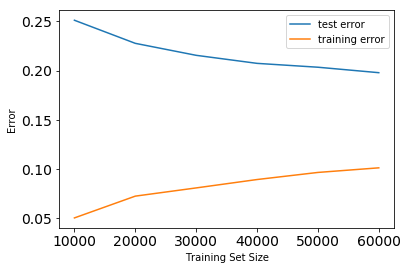

In [33]:
data_size=[10000,20000,30000,40000,50000,60000]
test_error=[]
train_error=[]
clf = MultinomialNB(alpha=.15)
X_train, X_test, y_train, y_test = train_test_split( X_train_tfidf, np.ravel(targets.values), test_size=0.3,random_state=42)
for i in data_size:
    clf.fit(X_train[0:i,:],y_train[0:i])
    train_pred=clf.predict(X_train[0:i,:])
    y_prediction = clf.predict(X_test)
    test_error.append(1-accuracy_score(y_true = y_test, y_pred = y_prediction))
    train_error.append(1-accuracy_score(y_true = y_train[0:i], y_pred = train_pred))
plt.plot(data_size,test_error,label='test error')
plt.plot(data_size,train_error,label='training error')
plt.legend()
plt.xlabel('Training Set Size')
plt.ylabel('Error')

We see that as I give the model more training data, its test error goes down and its training error goes up. This is a sign that the model is not underfitting the data and that if given more data it would continue to improve.

Finally, I examine my classifier to see which words most strongly influenced the model to classify a tweet as either Democrat or Republican. This is most straightforward using Logistic Regression.

The list of word coefficients is given by applying method,  '.coef_ '  to our classifier

In [59]:
LogisticRegression(C=10.0,fit_intercept=False,solver='sag',max_iter=5000).fit(X,y).coef_

array([[ 0.42225142, -0.62628947,  0.85865053, ...,  0.9750673 ,
        -0.54125047, -0.01188435]])

Next we order the coefficients, a higher negative value indicates a more Democrat correlated word and a higher positive value indicates a more Republican one. We find the ten lowest coefficents and look at their corresponding words

In [60]:
most=np.argsort(LogisticRegression(C=10.0,fit_intercept=False,solver='sag',max_iter=5000).fit(X,y).coef_)[0,0:11]
[count_vect.get_feature_names()[i] for i in most]

['goptaxscam',
 'energycommerce',
 'repdarrensoto',
 'netneutrality',
 'officialcbc',
 'hispaniccaucus',
 'repdwightevans',
 'oversightdems',
 'housejuddems',
 'trumpshutdown',
 'waysmeanscmte']

The viral hashtag #goptaxscam referring to the Republican tax bill is (obviously) a strong indicator of a Democratic tweet. In addition, one sees names of democratic congressmen like 'repdarrensoto' and progressive issues like 'netneutrality'.

Next I look at the most Republican correlated words:

In [61]:
most=np.argsort(LogisticRegression(C=10.0,fit_intercept=False,solver='sag',max_iter=5000).fit(X,y).coef_)[0,-11:-1]
for i in reversed([count_vect.get_feature_names()[i] for i in most]):
    print(i)

taxcutsandjobsact
justinamash
schumershutdown
housecommerce
graham
houseappropsgop
hascrepublicans
bonuses
repmarkwalker
jim_jordan


We see that the more positive description of the Republican tax bill, 'taxcutsandjobsact' is strongly correlated with Republicans, as well as names of Republican congressmen such as 'justinamash'.